In [263]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
import csv

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers

In [243]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
dataset_dir = 'C:/Users/ComputerLab3/Documents/Projet data science Aymen/genres/'

# 1) load a classical music:

In [7]:
import IPython.display as ipd
audiopath = dataset_dir + 'classical/'+'classical.00000.wav'
ipd.Audio(audiopath)

# Display the waveform of the music:

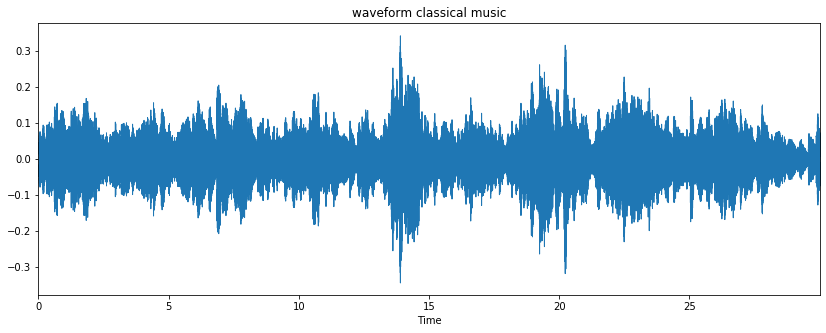

In [39]:
sound, sr = librosa.load(audiopath, duration = 30)
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
plt.title('waveform classical music')
librosa.display.waveplot(sound, sr=sr)

# Display the Spectrogram:

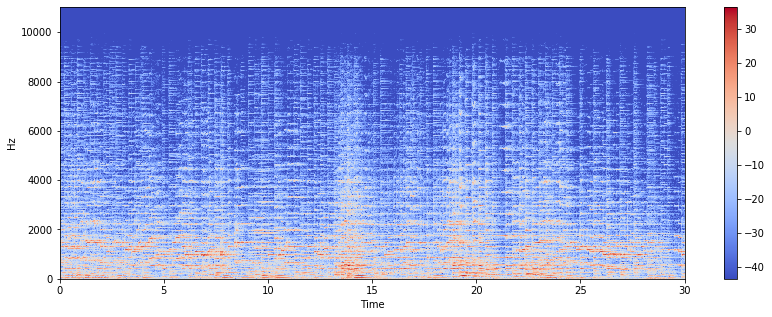

In [9]:

X = librosa.stft(sound)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
plt.title('Spectogram classical music')
plt.colorbar()

# Features: 

## Zero crossing rate: 
 The number of times the soundwave cross zero

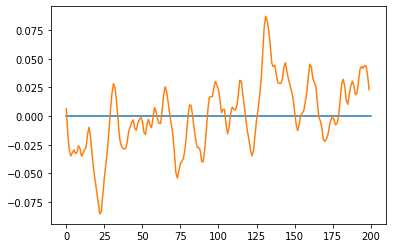

In [10]:
plt.plot([0,200],[0,0])
plt.plot(sound[9000:9200])

In [45]:
zero_crossings = librosa.zero_crossings(sound[9000:9200], pad=False)
print(sum(zero_crossings))

18


## Spectral Centroid: 


It is calculated as the [[weighted mean]] of the frequencies present in the signal, determined using a [[Fourier transform]], with their magnitudes as the weights:

$$
\mathrm{Centroid} = \frac{
  \sum_{n=0}^{N-1}
    f(n)
    x(n)
} {
  \sum_{n=0}^{N-1}
    x(n)
}
$$

where ''x(n)'' represents the weighted frequency value, or magnitude, of [[Histogram|bin]] number ''n'', and ''f(n)'' represents the center frequency of that bin.

<ref>[http://recherche.ircam.fr/equipes/analyse-synthese/peeters/ARTICLES/Peeters_2003_cuidadoaudiofeatures.pdf A Large Set of Audio Features for Sound Description] - technical report published by [[IRCAM]] in 2003. Section 6.1.1 describes the spectral centroid.</ref>

In [ ]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(sound, sr=sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(sound, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

In [13]:
spectral_centroids

array([1904.94016614, 1793.40234891, 1650.46990105, ..., 1262.80028746,
       1288.27231532, 1311.75244261])

## Rollof frequency: 
The frequency above or below which a filter begins to filter out the harmonics of the waveform.

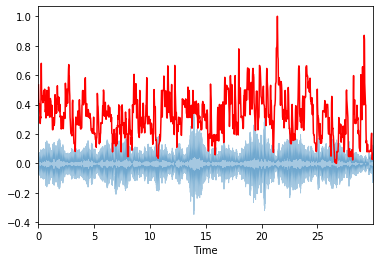

In [46]:
spectral_rolloff = librosa.feature.spectral_rolloff(sound, sr=sr)[0]
librosa.display.waveplot(sound, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

## Mel Frequency Cepstral Coefficients (MFCCs):
The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope. In MIR, it is often used to describe timbre.

(20, 1292)


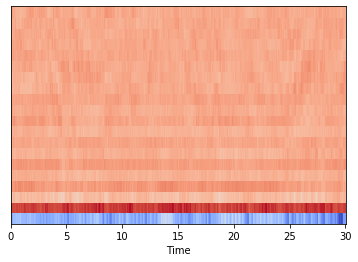

In [47]:
mfccs = librosa.feature.mfcc(sound, sr=sr)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## spectral contrast:
Spectral contrast considers the spectral peak, the spectral valley, and their difference in each frequency subband.

In [49]:
spectral_contrast = librosa.feature.spectral_contrast(sound, sr=sr)
spectral_contrast.shape

(7, 1292)

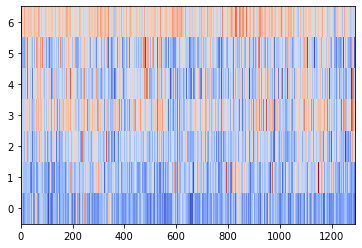

In [50]:
plt.imshow(normalize(spectral_contrast, axis=1), aspect='auto', origin='lower', cmap='coolwarm')

## spectral bandwidth:
It computes the order- p  spectral bandwidth:
$$\left( \sum_k S(k) \left(f(k) - f_c \right)^p \right)^{\frac{1}{p}}$$

where  S(k)  is the spectral magnitude at frequency bin  k ,  f(k)  is the frequency at bin  k , and  fc  is the spectral centroid. When  p=2 , this is like a weighted standard deviation.

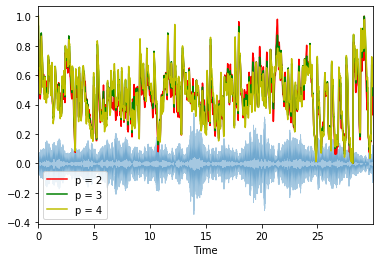

In [51]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(sound+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(sound+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(sound+0.01, sr=sr, p=4)[0]
librosa.display.waveplot(sound, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

## Spectral flatness:
Spectral flatness is defined as the ratio of the geometric mean to the arithmetic mean of a power spectrum.

In [53]:
spectral_flatness = librosa.feature.spectral_flatness(sound)
spectral_flatness.shape

(1, 1292)

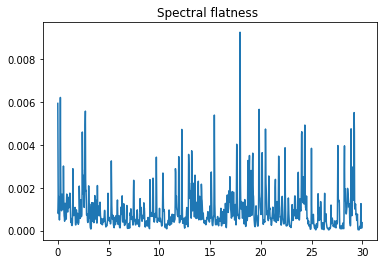

In [58]:
plt.plot(t, spectral_flatness.reshape(1292,1))
plt.title('Spectral flatness ')
plt.show()

## chroma_stft: 
Compute a chromagram from a waveform or power spectrogram.

# Extract the features:

In [27]:
def get_features(y, sr):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None, 'chroma_stft': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['chroma_stft']=librosa.feature.chroma_stft(y=y, sr=sr).ravel()
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr,).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y).ravel()
    features['rmse'] = librosa.feature.rms(y).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

In [37]:
def final_extraction(dataset_dir='C:/Users/ComputerLab3/Documents/Projet data science Aymen/genres/'):
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    last_features=[]
    for genre in genres:
        path_genre = dataset_dir + '/' + genre 

        for song in os.listdir(path_genre):        
            path_song = path_genre + '/' + song
            y, sr = librosa.load(path_song, duration = 30)
            features = get_features(y, sr)
            features['genre'] = genre
            last_features.append(features)
    return pd.DataFrame(last_features)

In [38]:
%%time

df_features = final_extraction()

Wall time: 17min 4s


## Export the data to a csv file:

In [43]:
df_features.to_csv('Data.csv', index=False)

## import the data:

In [244]:
df_features = pd.read_csv('Data.csv')

In [245]:
df_features.head()

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,...,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,genre
0,4031.364538,1027.079258,1784.420446,360.263361,5.246790,1.537974,7644.287109,1830.322266,3806.485316,949.558806,...,-0.189109,-0.110339,22.482096,-26.569305,-3.667368,6.422199,0.313302,-0.037197,123.046875,blues
1,5444.293577,421.091729,1529.835316,613.175361,4.028086,1.339397,8085.717773,333.764648,3548.820207,1725.249654,...,0.054884,0.154526,19.230034,-27.189579,-2.239120,8.055376,-0.182963,0.004210,107.666016,blues
2,4669.770713,417.254802,1552.481958,395.634070,11.609763,1.930126,6556.860352,441.430664,3040.514948,884.938380,...,0.542265,-0.682770,23.078028,-28.854303,-8.905224,7.774160,0.489465,0.710559,161.499023,blues
3,3236.442116,318.713500,1070.119953,429.532791,1.803354,1.001449,7611.987305,387.597656,2185.028454,1222.395194,...,1.569782,0.613722,20.651333,-32.890564,-2.476421,7.538023,0.499351,-0.163374,172.265625,blues
4,4464.156642,849.658285,1835.494603,585.961468,1.536058,1.049734,7084.423828,1152.026367,3580.945013,1253.915665,...,0.430401,0.456069,24.070387,-36.607307,-6.934123,9.466887,0.057030,0.132279,135.999178,blues


# Visualization: 

## Dimensionality reduction :

In [246]:
df_features.corr()

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,...,mfcc_11_std,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo
centroid_max,1.000000,0.123014,0.731945,0.847235,0.125641,0.185379,0.899234,0.085808,0.763007,0.669997,...,0.002129,-0.006964,-0.145709,0.116056,0.032494,0.193485,-0.017685,0.033974,-0.152891,-0.128402
centroid_min,0.123014,1.000000,0.589462,-0.230512,-0.065498,-0.107414,0.205249,0.964941,0.533963,-0.407034,...,-0.405671,-0.008969,-0.162732,-0.356962,-0.000617,-0.281248,-0.393007,0.031380,0.006524,-0.019909
centroid_mean,0.731945,0.589462,1.000000,0.543336,-0.208545,-0.278196,0.722191,0.557603,0.979633,0.230461,...,-0.234418,0.037301,-0.181124,-0.058288,0.074336,0.051260,-0.224407,0.061156,-0.107847,-0.104417
centroid_std,0.847235,-0.230512,0.543336,1.000000,-0.072267,0.035469,0.750197,-0.262646,0.583360,0.858888,...,0.134071,0.038251,-0.040817,0.280063,0.085107,0.355259,0.126585,0.050887,-0.164564,-0.106594
centroid_kurtosis,0.125641,-0.065498,-0.208545,-0.072267,1.000000,0.841375,0.086305,-0.063618,-0.210279,-0.005627,...,0.057456,-0.035899,-0.046433,-0.075711,-0.087178,-0.108759,0.001025,0.003917,0.007420,0.010384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mfcc_12_mean,0.193485,-0.281248,0.051260,0.355259,-0.108759,-0.066880,0.205285,-0.324102,0.081738,0.358877,...,0.222449,0.044980,0.136642,0.731193,0.648345,1.000000,0.254121,0.050623,0.033658,-0.038168
mfcc_12_std,-0.017685,-0.393007,-0.224407,0.126585,0.001025,0.022572,-0.155253,-0.393044,-0.233097,0.131323,...,0.813536,0.064691,0.250185,0.682186,-0.362663,0.254121,1.000000,0.058022,0.165441,-0.025120
mfcc_12_kurtosis,0.033974,0.031380,0.061156,0.050887,0.003917,0.009203,0.016836,0.021257,0.047387,0.013446,...,0.017319,0.444855,0.162459,0.353028,-0.127043,0.050623,0.058022,1.000000,0.373577,-0.036090
mfcc_12_skew,-0.152891,0.006524,-0.107847,-0.164564,0.007420,-0.006838,-0.145651,0.012524,-0.124865,-0.135524,...,0.105853,0.135726,0.139461,0.389271,0.220253,0.033658,0.165441,0.373577,1.000000,-0.035381


In [247]:
y = df_features['genre']
X = df_features.drop(columns=['genre'])

In [248]:
#Scale the data:
scale = StandardScaler()
x_scaled = pd.DataFrame(scale.fit_transform(X), columns = X.columns)

In [249]:
x_scaled.head()

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,...,mfcc_11_std,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo
0,-0.551119,0.327185,-0.583303,-1.020326,0.970654,0.943012,-0.272387,0.253342,-0.486166,-0.636384,...,-0.531473,-0.752266,-0.365011,0.019333,0.464418,0.183186,-0.900840,0.073169,-0.407109,0.098046
1,0.367633,-0.998428,-0.939066,-0.069368,0.610166,0.649882,-0.015867,-1.049596,-0.649869,0.930588,...,0.972199,-0.374373,0.426514,-0.292614,0.382568,0.414751,0.008729,-0.703958,-0.277323,-0.640715
2,-0.135998,-1.006822,-0.907419,-0.887331,2.852801,1.521889,-0.904303,-0.955859,-0.972811,-0.766924,...,-0.035540,0.380478,-2.075663,0.076496,0.162894,-0.666035,-0.147889,0.349031,1.936685,1.944950
3,-1.068013,-1.222383,-1.581483,-0.759871,-0.047903,0.151019,-0.291157,-1.002727,-1.516328,-0.085228,...,-0.653209,1.971888,1.798775,-0.156279,-0.369723,0.376277,-0.279401,0.364512,-0.802603,2.462083
4,-0.269697,-0.060928,-0.511931,-0.171694,-0.126968,0.222295,-0.597730,-0.337198,-0.629459,-0.021553,...,0.681089,0.207226,1.327645,0.171686,-0.860177,-0.346457,0.794846,-0.328141,0.124103,0.720161


In [250]:
#encode the genres:
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

In [251]:
y_enc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [252]:
pca = PCA(n_components=5, whiten=True)
x_pca = pca.fit_transform(x_scaled)
print("cumulative explained variance ratio = {:.4f}".format(np.sum(pca.explained_variance_ratio_)))

cumulative explained variance ratio = 0.5114


In [253]:
# Use LDA only for visualization
lda = LDA()
x_lda = lda.fit_transform(x_scaled, y_enc)

In [254]:
x_lda.shape

(1000, 9)

In [255]:
# Using tsne
tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.595s...
[t-SNE] Computed neighbors for 1000 samples in 0.521s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.325157
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.449799
[t-SNE] KL divergence after 1000 iterations: 1.019014


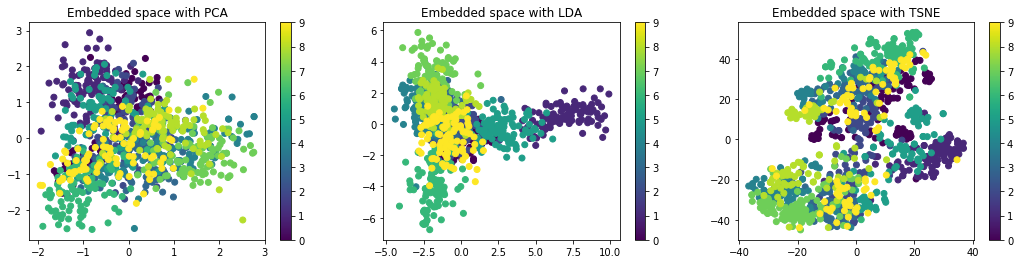

In [256]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.scatter(x_pca[:,0], x_pca[:,1], c=y_enc)
plt.colorbar()
plt.title("Embedded space with PCA")

plt.subplot(132)
plt.scatter(x_lda[:,0], x_lda[:,1], c=y_enc)
plt.colorbar()
plt.title("Embedded space with LDA")

plt.subplot(133)
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y_enc)
plt.colorbar()
plt.title("Embedded space with TSNE")
plt.show()

In [257]:
#Prepare the data:
X_train, X_test, y_train, y_test = train_test_split(x_lda, y_enc, test_size=0.3, random_state=42)

In [258]:
# First Model: Logistic Regression:
model_ml = 'LogisticRegression'
lg = LogisticRegression(max_iter=2000)
lg.fit(X_train,y_train)
y_pred=lg.predict(X_test)
Accuracy = accuracy_score(y_test, y_pred)
print('Accuracy for this model : '+model_ml+' is :'+str(Accuracy))

Accuracy for this model : LogisticRegression is :0.87


In [259]:
# 2nd model : RandomForestClassifier:
model_ml = 'RandomForest'
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
Accuracy = accuracy_score(y_test, y_pred)
print('Accuracy for this model : '+model_ml+' is :'+str(Accuracy))

Accuracy for this model : RandomForest is :0.6466666666666666


In [294]:
# 3rd model : Kera Neural Network: 
onehot_encoder = OneHotEncoder(sparse=False)
y_ohe_train = y_train.reshape(len(y_train), 1)
y_ohe_train = np.array(onehot_encoder.fit_transform(y_ohe_train))
y_ohe_test = y_test.reshape(len(y_test), 1)
y_ohe_test = np.array(onehot_encoder.fit_transform(y_ohe_test))

#y_ohe_test = np_utils.to_categorical(y_test)
model = tf.keras.Sequential([
layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(9,1)),
layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
layers.Dropout(0.5),
layers.MaxPooling1D(pool_size=3),
layers.Flatten(),
layers.Dense(100, activation='relu'),
layers.Dense(10, activation='softmax')])



model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=['AUC','Accuracy','Precision','Recall'])
model.fit(X_train, y_ohe_train,epochs=3)
loss,AUC, Accuracy_test,Precision,Recall = model.evaluate(X_test, y_ohe_test)
F1_score = 2*Precision*Recall/(Precision+Recall)
y_pred = model.predict(X_test)
print('Accuracy is :' + str(Accuracy_test))

ValueError: Error when checking input: expected conv1d_32_input to have 3 dimensions, but got array with shape (700, 9)

In [293]:
X_train.shape

(700, 9)

In [ ]:
Accuracy = accuracy_score(y_test, [np.argmax(y_pred[i]) for i in range(len(y_pred))])

In [ ]:
Accuracy

In [267]:
nvb = GaussianNB()
nvb.fit(X_train,y_train)
y_pred=nvb.predict(X_test)
#AUC = roc_auc_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.8766666666666667